In [1]:
tr_dir_base = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
ts_dir_base = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/"

tr_dir_normal = tr_dir_base + "NORMAL/"
ts_dir_normal = ts_dir_base + "NORMAL/"

tr_dir_pnemon = tr_dir_base + "PNEUMONIA/"
ts_dir_pnemon = ts_dir_base + "PNEUMONIA/"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.image as img
from PIL import Image
import cv2

import torch, torchvision
from torchvision import models
from torch import optim, nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.optim.lr_scheduler as LR
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.model_selection import KFold

import random as r
import os
from time import time

MAX_VALUE = 255

In [3]:
def breaker():
    print("\n" + 30*"-" + "\n")
    
def head(x, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()

def getFileNames(root_dir=None):
    f_name = []
    for dirname, _, filenames in os.walk(root_dir):
        for filename in filenames:
            f_name.append(filename)
    return f_name

def removeChannelInfo(file_path=None, file_names=None, size=None):
    sizes = []
    images = []
    for name in file_names:
        image = cv2.imread(file_path+name)
        if len(image.shape) > 2:
            image = image[:, :, -1]
        sizes.append(image.shape)
        images.append(cv2.resize(image, dsize=(size, size), interpolation=cv2.INTER_LANCZOS4))
    return images, sizes

In [4]:
tr_normal_file_names = getFileNames(tr_dir_normal)
tr_pnemon_file_names = getFileNames(tr_dir_pnemon)
ts_normal_file_names = getFileNames(ts_dir_normal)
ts_pnemon_file_names = getFileNames(ts_dir_pnemon)

start_time = time()

n_size = 127
trn_images, trn_sizes = removeChannelInfo(tr_dir_normal, tr_normal_file_names, n_size)
trp_images, trp_sizes = removeChannelInfo(tr_dir_pnemon, tr_pnemon_file_names, n_size)

tsn_images, tsn_sizes = removeChannelInfo(ts_dir_normal, ts_normal_file_names, n_size)
tsp_images, tsp_sizes = removeChannelInfo(ts_dir_pnemon, ts_pnemon_file_names, n_size)

print("Time Taken to process data : {:.2f} minutes".format((time()-start_time)/60))

Time Taken to process data : 1.97 minutes


In [5]:
tr_images = np.concatenate((trn_images, trp_images), axis=0)
tr_images = np.divide(tr_images, MAX_VALUE)
tr_labels = np.concatenate((np.zeros((len(trn_images))), np.ones((len(trp_images)))), axis=0)

print(tr_images.shape)
print(tr_labels.shape)

ts_images = np.concatenate((tsn_images, tsp_images), axis=0)
ts_images = np.divide(ts_images, MAX_VALUE)
ts_labels = np.concatenate((np.zeros((len(tsn_images))), np.ones((len(tsp_images)))), axis=0)

print(ts_images.shape)
print(ts_labels.shape)

num_obs_test = ts_labels.shape[0]

(5216, 127, 127)
(5216,)
(624, 127, 127)
(624,)


In [6]:
class DS(Dataset):
    def __init__(this, X=None, y=None, mode="train"):
        this.mode = mode
        this.X = X
        if mode == "train":
            this.y = y
        
    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        if this.mode == "train":
            return torch.FloatTensor(this.X[idx]), torch.FloatTensor(this.y[idx])
        else:
            return torch.FloatTensor(this.X[idx])

In [7]:
model = models.vgg16(pretrained=True, progress=True)

for params in model.parameters():
    params.requires_grad = False

torch.manual_seed(0)
model.features[0]   = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
model.classifier[6] = nn.Linear(4096, 1)

breaker()
for names, params in model.named_parameters():
    if params.requires_grad == True:
        print(names)
breaker()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth




------------------------------

features.0.weight
features.0.bias
classifier.6.weight
classifier.6.bias

------------------------------



In [8]:
class CFG():
    tr_batch_size = 128
    ts_batch_size = 128
    epochs = 25
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
cfg = CFG()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

breaker()
print("Train Batch Size :", repr(cfg.tr_batch_size))
print("Test Batch Size  :", repr(cfg.ts_batch_size))
print("Epochs           :", repr(cfg.epochs))
print("Device Used      :", cfg.device)
print("\nOptimizer        :", optimizer)
breaker()

tr_data_setup = DS(tr_images, tr_labels.reshape(-1,1))
ts_data_setup = DS(ts_images, ts_labels.reshape(-1,1))

dataloaders = {"train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
               "test"  : DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)}


------------------------------

Train Batch Size : 128
Test Batch Size  : 128
Epochs           : 25
Device Used      : cuda:0

Optimizer        : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-05
)

------------------------------




------------------------------

Time taken to train for 25 epochs : 5.73 minutes

------------------------------



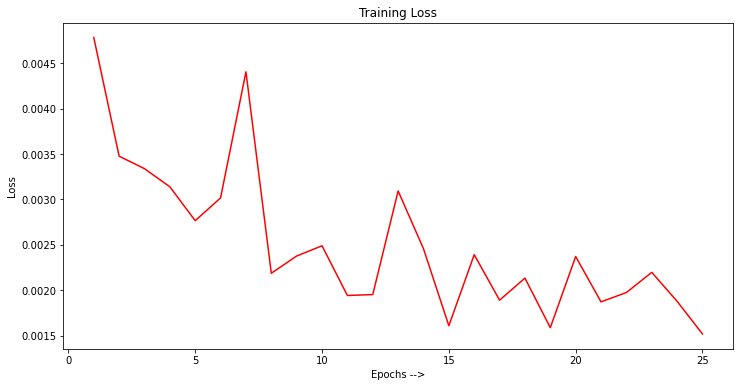

In [9]:
start_time = time()
LP = []

model.to(cfg.device)
model.train()
for e in range(cfg.epochs):
    lossPerPass = 0
    
    for feats, label in dataloaders["train"]:
        feats, label = feats.to(cfg.device).view(feats.shape[0], 1, n_size, n_size), label.to(cfg.device)
        
        optimizer.zero_grad()
        output = model(feats)
        loss   = nn.BCEWithLogitsLoss()(output, label)
        loss.backward()
        lossPerPass = (loss.item()/label.shape[0])
        optimizer.step()
    LP.append(lossPerPass)
    
breaker()
print("Time taken to train for {e} epochs : {:.2f} minutes".format((time()-start_time)/60, e=cfg.epochs))
breaker()

x_Axis = [i+1 for i in range(cfg.epochs)]

plt.figure(figsize=(12, 6))
plt.plot(x_Axis, LP, "r")
plt.xlabel("Epochs -->")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [10]:
model.eval()

Pred = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)
for X, y in dataloaders["test"]:
    X = X.to(cfg.device).view(X.shape[0], 1, n_size, n_size)
    with torch.no_grad():
        logProb = model(X)
    Prob = torch.exp(logProb)
    Pred = torch.cat((Pred, Prob), dim=0)
Pred = Pred[cfg.ts_batch_size:]
Pred = Pred.cpu().numpy().reshape(-1)
Pred[np.argwhere(Pred > 0.5)[:, 0]]  = int(1)
Pred[np.argwhere(Pred <= 0.5)[:, 0]] = int(0)


breaker()
print("ANN Model Accuracy  : {:.5f} %".format(accuracy_score(ts_labels, Pred) * 100))
breaker()


------------------------------

ANN Model Accuracy  : 77.88462 %

------------------------------

